In [394]:
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric
import math
from math import *

In [395]:
#Unnamed: unique identifier for each trip
#fare_amount: cost of each trip in USD
df_fare = pd.read_csv('uber.csv')
df_fare

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [396]:
df_fare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


## Data cleaning

In [397]:
#drop NA and redundant columns: key and passenger_count
df_fare.dropna(axis=0,inplace=True)
df_fare = df_fare.drop(['Unnamed: 0','key','passenger_count'],axis=1)

In [398]:
df_fare.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890
std,9.901760,11.437815,7.720558,13.117408,6.794829
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001
max,499.000000,57.418457,1644.421482,1153.572603,872.697628


In [410]:
#remove outlier - lat/long out of range
df_fare.drop(df_fare[(df_fare['pickup_longitude']>=180) | (df_fare['pickup_longitude']<=-180)].index, axis = 0, inplace = True)
df_fare.drop(df_fare[(df_fare['dropoff_longitude']>=180) | (df_fare['dropoff_longitude']<=-180)].index, axis = 0, inplace = True)

df_fare.drop(df_fare[(df_fare['pickup_latitude']>=90) | (df_fare['pickup_latitude']<=-90)].index, axis = 0, inplace = True)
df_fare.drop(df_fare[(df_fare['dropoff_latitude']>=90) | (df_fare['dropoff_latitude']<=-90)].index, axis = 0, inplace = True)

In [411]:
#remove outlier - negative fare
df_fare = df_fare.loc[df_fare['fare_amount']>0]

## Feature engineering
- calculate haversine distance
- convert USD to SGD
- calculate different time dimensions

In [388]:
import haversine
from haversine import haversine, Unit

In [413]:
#calculate haversine distance
def haversineDist(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    pick_up = (pickup_lat,pickup_long)
    drop_off = (dropoff_lat, dropoff_long)
    dist = haversine(pick_up, drop_off)
    return dist

In [390]:
haversineDist(103.83509069699788,103.82218034117531,1.4294942539354443,1.2646177435329846)

18.389544682428273

In [414]:
#calculate and add haversine distance in km to original dataset
df_fare = df_fare.reset_index()
df_fare['distance_km'] = 0.00
for i in range(len(df_fare)):
    df_fare['distance_km'][i] = haversineDist(df_fare['pickup_longitude'][i],df_fare['dropoff_longitude'][i],df_fare['pickup_latitude'][i],df_fare['dropoff_latitude'][i])

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/1564082135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['distance_km'][i] = haversineDist(df_fare['pickup_longitude'][i],df_fare['dropoff_longitude'][i],df_fare['pickup_latitude'][i],df_fare['dropoff_latitude'][i])


In [415]:
#convert USD to SGD -- 1.35
df_fare['fare_sg'] = round(df_fare['fare_amount']*1.35,2)

In [416]:
#add different time dimensions
from datetime import datetime
#df_fare['date'] = pd.to_datetime(df_fare['pickup_datetime']).dt.date
df_fare['year'] = pd.to_datetime(df_fare['pickup_datetime']).dt.year
df_fare['month'] = pd.to_datetime(df_fare['pickup_datetime']).dt.month
df_fare['day'] = pd.to_datetime(df_fare['pickup_datetime']).dt.day
df_fare['day_of_week'] = pd.to_datetime(df_fare['pickup_datetime']).dt.day_name()
df_fare['hour'] = pd.to_datetime(df_fare['pickup_datetime']).dt.hour
df_fare['minute'] = pd.to_datetime(df_fare['pickup_datetime']).dt.minute
#df_fare['time'] = pd.to_datetime(df_fare['pickup_datetime']).dt.time

In [417]:
#drop columns with negative and zero distance
df_fare = df_fare.loc[df_fare['distance_km']>0]

In [419]:
df_fare.describe()

,distance_km,fare_sg,year,month,day,hour,minute
count,194335.000000,194335.000000,194335.000000,194335.000000,194335.000000,194335.000000,194335.000000
mean,21.068881,15.333678,2011.747215,6.281313,15.704238,13.488363,29.527044
std,384.085752,13.159938,1.860040,3.440385,8.687829,6.515155,17.339450
min,0.000084,0.010000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,1.281829,8.100000,2010.000000,3.000000,8.000000,9.000000,14.000000
50%,2.184348,11.480000,2012.000000,6.000000,16.000000,14.000000,30.000000
75%,3.959835,16.880000,2013.000000,9.000000,23.000000,19.000000,45.000000
max,8782.910738,673.650000,2015.000000,12.000000,31.000000,23.000000,59.000000


In [247]:
#drop outliers
#df_fare.drop(df_fare[(df_fare['fare_sg']>100)&(df_fare['distance_km']<10)].index, axis = 0, inplace = True)

In [418]:
#drop unnes columns
df_fare = df_fare.drop(['index','pickup_datetime','pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude','fare_amount'],axis=1)

In [421]:
#weekend indicator
df_fare['weekend'] = 2
df_fare['weekend'].loc[(df_fare['day_of_week'] == "Monday") | (df_fare['day_of_week'] =="Tuesday") | (df_fare['day_of_week'] =="Wednesday") | (df_fare['day_of_week'] =="Thursday") | (df_fare['day_of_week'] =="Friday")] = 0
df_fare['weekend'].loc[(df_fare['day_of_week'] == "Saturday") | (df_fare['day_of_week'] =="Sunday")] = 1


/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/2186011891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['weekend'].loc[(df_fare['day_of_week'] == "Monday") | (df_fare['day_of_week'] =="Tuesday") | (df_fare['day_of_week'] =="Wednesday") | (df_fare['day_of_week'] =="Thursday") | (df_fare['day_of_week'] =="Friday")] = 0
/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/2186011891.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['weekend'].loc[(df_fare['day_of_week'] == "Saturday") | (df_fare['day_of_week'] =="Sunday")] = 1


In [422]:
#final cleaned dataset
df_fare

,distance_km,fare_sg,year,month,day,day_of_week,hour,minute,weekend
0,1.683325,10.12,2015,5,7,Thursday,19,52,0
1,2.457593,10.40,2009,7,17,Friday,20,4,0
2,5.036384,17.42,2009,8,24,Monday,21,45,0
3,1.661686,7.16,2009,6,26,Friday,8,22,0
4,4.475456,21.60,2014,8,28,Thursday,17,47,0
...,...,...,...,...,...,...,...,...,...
199960,0.112210,4.05,2012,10,28,Sunday,10,49,1
199961,1.875053,10.12,2014,3,14,Friday,1,9,0
199962,12.850337,41.72,2009,6,29,Monday,0,42,0
199963,3.539720,19.58,2015,5,20,Wednesday,14,56,0


# Scale fare_sg based on Grab SG price

## Grab data

In [425]:
grabsg = pd.read_csv('sg_grab.csv')
grabsg

,pickup_address,droppoff_address,time,justgrab,grabcar,grabcar6,pickup_longlat,dropoff_longlat
0,"Ocean Financial Centre, 049315",51 Telok Ayer St 048441,2023-03-01 17:29:00 UTC,10.26,11.21,12.16,"1.283422043524126, 103.85203242556372","1.2831500912513192, 103.84927752926207"
1,"Hong Leong Building, 048581",51 Telok Ayer St 048441,2023-03-01 17:31:00 UTC,10.26,11.21,11.21,"1.2815918005732743, 103.85098625439927","1.2831500912513192, 103.84927752926207"
2,"Alkaff Cres, 340123",52 Telok Ayer St 048441,2023-03-01 17:32:00 UTC,15.96,16.91,26.41,"1.3363568692270062, 103.87359619672816","1.2831500912513192, 103.84927752926207"
3,"211 Serangoon Ave 4, 550211","Simei St 1, 520120",2023-03-01 17:35:00 UTC,16.91,18.81,25.46,"1.358414834681329, 103.87070059672817","1.3457371175363357, 103.95439555309876"
4,"Guoco Tower, Tanjong Pagar Centre, 078881","ION Orchard, 238801",2023-03-02 14:35:00 UTC,10.26,11.21,13.11,"1.2771655224876894, 103.84582909672807","1.3040789638513597, 103.83194919672815"
5,"124A Rivervale Drive, 541124","Terminal 1 - Changi Airport, 819663",2023-03-02 14:37:00 UTC,22.61,24.51,38.76,"1.3886431613240113, 103.90225519672819","1.357702710156134, 103.98650994874131"
6,"Tuas Link MRT Station (EW33), 638418","Tampines 1, 529536",2023-03-02 14:39:00 UTC,33.06,36.86,52.06,"1.339929787559795, 103.63669902556377","1.3542388899643198, 103.94536919672817"
7,"Tuas Link MRT Station (EW33), 638419","6 Serangoon North Ave 5, 554910",2023-03-02 14:41:00 UTC,30.21,33.04,47.31,"1.339929787559795, 103.63669902556377","1.3743222367476735, 103.86908116789259"
8,"Bishan Loft, 579821","6 Serangoon North Ave 5, 554910",2023-03-02 14:42:00 UTC,16.91,18.81,23.56,"1.347464635318663, 103.85234756604335","1.3743222367476735, 103.86908116789259"
9,"Bishan MRT, 579827","Bishan Loft, 579821",2023-03-02 14:45:00 UTC,9.31,10.26,11.21,"1.3510462453604495, 103.84868931022135","1.347464635318663, 103.85234756604335"


In [426]:
#add haversine distance from longlat
grabsg['haversine'] = -1
for i in range(len(grabsg)):
    pickuplat = float(grabsg['pickup_longlat'][i].split(',')[0])
    pickuplong = float(grabsg['pickup_longlat'][i].split(',')[1])
    dropofflat = float(grabsg['dropoff_longlat'][i].split(',')[0])
    dropofflong = float(grabsg['dropoff_longlat'][i].split(',')[1])
    grabsg['haversine'][i] = haversineDist(pickuplong, dropofflong, pickuplat, dropofflat)

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/3852910848.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grabsg['haversine'][i] = haversineDist(pickuplong, dropofflong, pickuplat, dropofflat)


In [427]:
1.4294942539354443, 103.83509069699788
1.2646177435329846, 103.82218034117531
haversineDist(103.83509069699788, 103.82218034117531, 1.4294942539354443, 1.2646177435329846)

18.389544682428273

In [428]:
#calculate price/km
grabsg['justgrab_haversine'] = grabsg['justgrab']/grabsg['haversine']

In [429]:
#calculate price/km of original dataset
df_fare['price_haversine'] = df_fare['fare_sg']/df_fare['distance_km']

In [430]:
df_fare[['distance_km','price_haversine']].describe()

,distance_km,price_haversine
count,194335.000000,194335.000000
mean,21.068881,114.770391
std,384.085752,6241.791483
min,0.000084,0.000390
25%,1.281829,4.002363
50%,2.184348,5.155193
75%,3.959835,6.818197
max,8782.910738,901778.539960


In [431]:
grabsg[['haversine','justgrab_haversine']].describe()

,haversine,justgrab_haversine
count,18.000000,18.000000
mean,9.442784,10.375489
std,12.000605,13.709860
min,0.187025,0.937475
25%,0.607180,1.518085
50%,5.011552,2.750411
75%,10.592689,14.506802
max,39.318364,39.904788


In [432]:
grabsg

,pickup_address,droppoff_address,time,justgrab,grabcar,grabcar6,pickup_longlat,dropoff_longlat,haversine,justgrab_haversine
0,"Ocean Financial Centre, 049315",51 Telok Ayer St 048441,2023-03-01 17:29:00 UTC,10.26,11.21,12.16,"1.283422043524126, 103.85203242556372","1.2831500912513192, 103.84927752926207",0.307743,33.339463
1,"Hong Leong Building, 048581",51 Telok Ayer St 048441,2023-03-01 17:31:00 UTC,10.26,11.21,11.21,"1.2815918005732743, 103.85098625439927","1.2831500912513192, 103.84927752926207",0.257112,39.904788
2,"Alkaff Cres, 340123",52 Telok Ayer St 048441,2023-03-01 17:32:00 UTC,15.96,16.91,26.41,"1.3363568692270062, 103.87359619672816","1.2831500912513192, 103.84927752926207",6.504722,2.453602
3,"211 Serangoon Ave 4, 550211","Simei St 1, 520120",2023-03-01 17:35:00 UTC,16.91,18.81,25.46,"1.358414834681329, 103.87070059672817","1.3457371175363357, 103.95439555309876",9.410067,1.797012
4,"Guoco Tower, Tanjong Pagar Centre, 078881","ION Orchard, 238801",2023-03-02 14:35:00 UTC,10.26,11.21,13.11,"1.2771655224876894, 103.84582909672807","1.3040789638513597, 103.83194919672815",3.367003,3.047220
5,"124A Rivervale Drive, 541124","Terminal 1 - Changi Airport, 819663",2023-03-02 14:37:00 UTC,22.61,24.51,38.76,"1.3886431613240113, 103.90225519672819","1.357702710156134, 103.98650994874131",9.977922,2.266003
6,"Tuas Link MRT Station (EW33), 638418","Tampines 1, 529536",2023-03-02 14:39:00 UTC,33.06,36.86,52.06,"1.339929787559795, 103.63669902556377","1.3542388899643198, 103.94536919672817",34.349988,0.962446
7,"Tuas Link MRT Station (EW33), 638419","6 Serangoon North Ave 5, 554910",2023-03-02 14:41:00 UTC,30.21,33.04,47.31,"1.339929787559795, 103.63669902556377","1.3743222367476735, 103.86908116789259",26.114043,1.156849
8,"Bishan Loft, 579821","6 Serangoon North Ave 5, 554910",2023-03-02 14:42:00 UTC,16.91,18.81,23.56,"1.347464635318663, 103.85234756604335","1.3743222367476735, 103.86908116789259",3.518382,4.806186
9,"Bishan MRT, 579827","Bishan Loft, 579821",2023-03-02 14:45:00 UTC,9.31,10.26,11.21,"1.3510462453604495, 103.84868931022135","1.347464635318663, 103.85234756604335",0.569199,16.356325


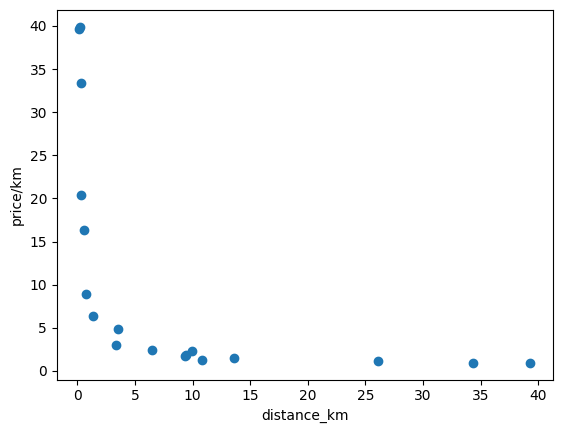

In [442]:
import matplotlib.pyplot as plt

plt.scatter(grabsg['haversine'], grabsg['justgrab_haversine'])
plt.xlabel('distance_km')
plt.ylabel('price/km')
#plt.xlim(0,15)
plt.show()

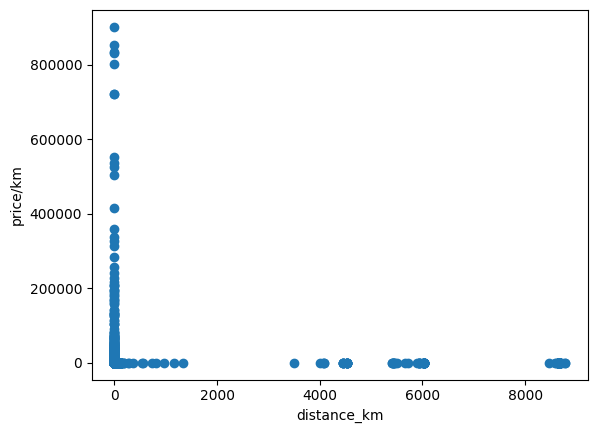

In [441]:
plt.scatter(df_fare['distance_km'], df_fare['price_haversine'])
plt.xlabel('distance_km')
plt.ylabel('price/km')
#plt.xlim(0,200)
plt.show()

In [443]:
#re-group distance since price/km is exponentially decreasing with distance
grabsg['dist_group'] = -1
grabsg['dist_group'].loc[(grabsg['haversine']<=0.1)] = 0
grabsg['dist_group'].loc[(grabsg['haversine']>0.1) & (grabsg['haversine']<=0.2)] = 1
grabsg['dist_group'].loc[(grabsg['haversine']>0.2) & (grabsg['haversine']<=0.3)] = 2
grabsg['dist_group'].loc[(grabsg['haversine']>0.3) & (grabsg['haversine']<=0.4)] = 3
grabsg['dist_group'].loc[(grabsg['haversine']>0.4) & (grabsg['haversine']<=0.5)] = 4
grabsg['dist_group'].loc[(grabsg['haversine']>0.5) & (grabsg['haversine']<=0.6)] = 5
grabsg['dist_group'].loc[(grabsg['haversine']>0.6) & (grabsg['haversine']<=0.8)] = 6
grabsg['dist_group'].loc[(grabsg['haversine']>0.8) & (grabsg['haversine']<=1.0)] = 7
grabsg['dist_group'].loc[(grabsg['haversine']>1.0) & (grabsg['haversine']<=1.5)] = 8
grabsg['dist_group'].loc[(grabsg['haversine']>1.5) & (grabsg['haversine']<=2)] = 9
grabsg['dist_group'].loc[(grabsg['haversine']>2) & (grabsg['haversine']<=2.5)] = 10
grabsg['dist_group'].loc[(grabsg['haversine']>2.5) & (grabsg['haversine']<=3)] = 11
grabsg['dist_group'].loc[(grabsg['haversine']>3) & (grabsg['haversine']<=4)] = 12
grabsg['dist_group'].loc[(grabsg['haversine']>4) & (grabsg['haversine']<=5)] = 13
grabsg['dist_group'].loc[(grabsg['haversine']>5) & (grabsg['haversine']<=7)] = 14
grabsg['dist_group'].loc[(grabsg['haversine']>7) & (grabsg['haversine']<=10)] = 15
grabsg['dist_group'].loc[(grabsg['haversine']>10) & (grabsg['haversine']<=15)] = 16
grabsg['dist_group'].loc[(grabsg['haversine']>15)] = 17

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/1186752186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grabsg['dist_group'].loc[(grabsg['haversine']<=0.1)] = 0
/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/1186752186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grabsg['dist_group'].loc[(grabsg['haversine']>0.1) & (grabsg['haversine']<=0.2)] = 1
/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/1186752186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [444]:
#re-group distance since price/km is exponentially decreasing with distance
df_fare['dist_group'] = -1
df_fare['dist_group'].loc[(df_fare['distance_km']<=0.1)] = 0
df_fare['dist_group'].loc[(df_fare['distance_km']>0.1) & (df_fare['distance_km']<=0.2)] = 1
df_fare['dist_group'].loc[(df_fare['distance_km']>0.2) & (df_fare['distance_km']<=0.3)] = 2
df_fare['dist_group'].loc[(df_fare['distance_km']>0.3) & (df_fare['distance_km']<=0.4)] = 3
df_fare['dist_group'].loc[(df_fare['distance_km']>0.4) & (df_fare['distance_km']<=0.5)] = 4
df_fare['dist_group'].loc[(df_fare['distance_km']>0.5) & (df_fare['distance_km']<=0.6)] = 5
df_fare['dist_group'].loc[(df_fare['distance_km']>0.6) & (df_fare['distance_km']<=0.8)] = 6
df_fare['dist_group'].loc[(df_fare['distance_km']>0.8) & (df_fare['distance_km']<=1.0)] = 7
df_fare['dist_group'].loc[(df_fare['distance_km']>1.0) & (df_fare['distance_km']<=1.5)] = 8
df_fare['dist_group'].loc[(df_fare['distance_km']>1.5) & (df_fare['distance_km']<=2)] = 9
df_fare['dist_group'].loc[(df_fare['distance_km']>2) & (df_fare['distance_km']<=2.5)] = 10
df_fare['dist_group'].loc[(df_fare['distance_km']>2.5) & (df_fare['distance_km']<=3)] = 11
df_fare['dist_group'].loc[(df_fare['distance_km']>3) & (df_fare['distance_km']<=4)] = 12
df_fare['dist_group'].loc[(df_fare['distance_km']>4) & (df_fare['distance_km']<=5)] = 13
df_fare['dist_group'].loc[(df_fare['distance_km']>5) & (df_fare['distance_km']<=7)] = 14
df_fare['dist_group'].loc[(df_fare['distance_km']>7) & (df_fare['distance_km']<=10)] = 15
df_fare['dist_group'].loc[(df_fare['distance_km']>10) & (df_fare['distance_km']<=15)] = 16
df_fare['dist_group'].loc[(df_fare['distance_km']>15)] = 17

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/74826082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['dist_group'].loc[(df_fare['distance_km']<=0.1)] = 0
/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/74826082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['dist_group'].loc[(df_fare['distance_km']>0.1) & (df_fare['distance_km']<=0.2)] = 1
/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/74826082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

Grab

dist_group price/km
0     1.941415
1     1.946890
2     0.986579
3     0.356747
4     0.398101
5     0.287386
6     0.176670
7     0.153086
8     0.129501
9     0.124263
10    0.119025
11    0.108549
12    0.087806
13    0.072228

In [446]:
grabsg.groupby(['dist_group'])['justgrab_haversine'].mean()

dist_group
1     39.620363
2     39.904788
3     26.856049
5     16.356325
6      8.958233
8      6.315835
12     3.926703
14     2.453602
15     1.923392
16     1.378600
17     1.018923
Name: justgrab_haversine, dtype: float64

In [447]:
df_fare.groupby(['dist_group'])['price_haversine'].mean()

dist_group
0     18014.263801
1        78.732347
2        33.052331
3        19.413967
4        13.969712
5        11.838701
6         9.622886
7         8.227278
8         6.918441
9         5.864683
10        5.267560
11        4.850963
12        4.438967
13        4.083453
14        3.791888
15        3.836973
16        3.586727
17        3.129584
Name: price_haversine, dtype: float64

In [445]:
#find difference in price/km between 2 datasets
diff_in_rate = (grabsg.groupby(['dist_group'])['justgrab_haversine'].mean()/df_fare.groupby(['dist_group'])['price_haversine'].mean()).to_frame()
diff_in_rate

,0
dist_group,
0,NaN
1,0.503229
2,1.207321
3,1.383336
4,NaN
5,1.381598
6,0.930930
7,NaN
8,0.912899


In [450]:
#fill missing group (grab sample dataset is small)
diff_in_rate[0][0] = 0.503229
diff_in_rate[0][4] = (1.383336+1.381598)/2
diff_in_rate[0][7] = (0.930930+0.912899)/2
diff_in_rate[0][9] = 0.912899 - (0.912899-0.884598)/4
diff_in_rate[0][10] = 0.912899 - (0.912899-0.884598)/2
diff_in_rate[0][11] = 0.912899 - (0.912899-0.884598)/4*3
diff_in_rate[0][13] = (0.884598+0.647066)/2

In [451]:
diff_in_rate

,0
dist_group,
0,0.503229
1,0.503229
2,1.207321
3,1.383336
4,1.382467
5,1.381598
6,0.930930
7,0.921914
8,0.912899


In [452]:
#calculate adjusted fare on original dataset by scaling fare_sg according to diff_in_rate
df_fare['fare_adj'] = -1
df_fare['fare_adj'].loc[(df_fare['dist_group']== 0)] = df_fare['fare_sg'] * diff_in_rate[0][0]
df_fare['fare_adj'].loc[(df_fare['dist_group']==1)] =df_fare['fare_sg'] * diff_in_rate[0][1]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 2)] =df_fare['fare_sg'] * diff_in_rate[0][2]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 3)] = df_fare['fare_sg'] * diff_in_rate[0][3]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 4)] =df_fare['fare_sg'] * diff_in_rate[0][4]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 5)]=df_fare['fare_sg'] * diff_in_rate[0][5]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 6)]=df_fare['fare_sg'] * diff_in_rate[0][6]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 7)]=df_fare['fare_sg'] * diff_in_rate[0][7]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 8)]=df_fare['fare_sg'] * diff_in_rate[0][8]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 9)]=df_fare['fare_sg'] * diff_in_rate[0][9]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 10)]=df_fare['fare_sg'] * diff_in_rate[0][10]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 11)]=df_fare['fare_sg'] * diff_in_rate[0][11]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 12)]=df_fare['fare_sg'] * diff_in_rate[0][12]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 13)]=df_fare['fare_sg'] * diff_in_rate[0][13]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 14)]=df_fare['fare_sg'] * diff_in_rate[0][14]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 15)]=df_fare['fare_sg'] * diff_in_rate[0][15]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 16)]=df_fare['fare_sg'] * diff_in_rate[0][1]
df_fare['fare_adj'].loc[(df_fare['dist_group']== 17)]=df_fare['fare_sg'] * diff_in_rate[0][17]

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/1400362794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fare['fare_adj'].loc[(df_fare['dist_group']== 0)] = df_fare['fare_sg'] * diff_in_rate[0][0]


In [453]:
df_fare['fare_adj'] = round(df_fare['fare_adj'],2)

In [454]:
#dataset with adjusted price
df_fare

,distance_km,fare_sg,year,month,day,day_of_week,hour,minute,weekend,price_haversine,dist_group,fare_adj
0,1.683325,10.12,2015,5,7,Thursday,19,52,0,6.011911,9,9.17
1,2.457593,10.40,2009,7,17,Friday,20,4,0,4.231782,10,9.35
2,5.036384,17.42,2009,8,24,Monday,21,45,0,3.458831,14,11.27
3,1.661686,7.16,2009,6,26,Friday,8,22,0,4.308877,9,6.49
4,4.475456,21.60,2014,8,28,Thursday,17,47,0,4.826324,13,16.54
...,...,...,...,...,...,...,...,...,...,...,...,...
199960,0.112210,4.05,2012,10,28,Sunday,10,49,1,36.092911,1,2.04
199961,1.875053,10.12,2014,3,14,Friday,1,9,0,5.397181,9,9.17
199962,12.850337,41.72,2009,6,29,Monday,0,42,0,3.246607,16,20.99
199963,3.539720,19.58,2015,5,20,Wednesday,14,56,0,5.531510,12,17.32


## Correlation plot

In [455]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/3899944808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_fare.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')


<AxesSubplot: >

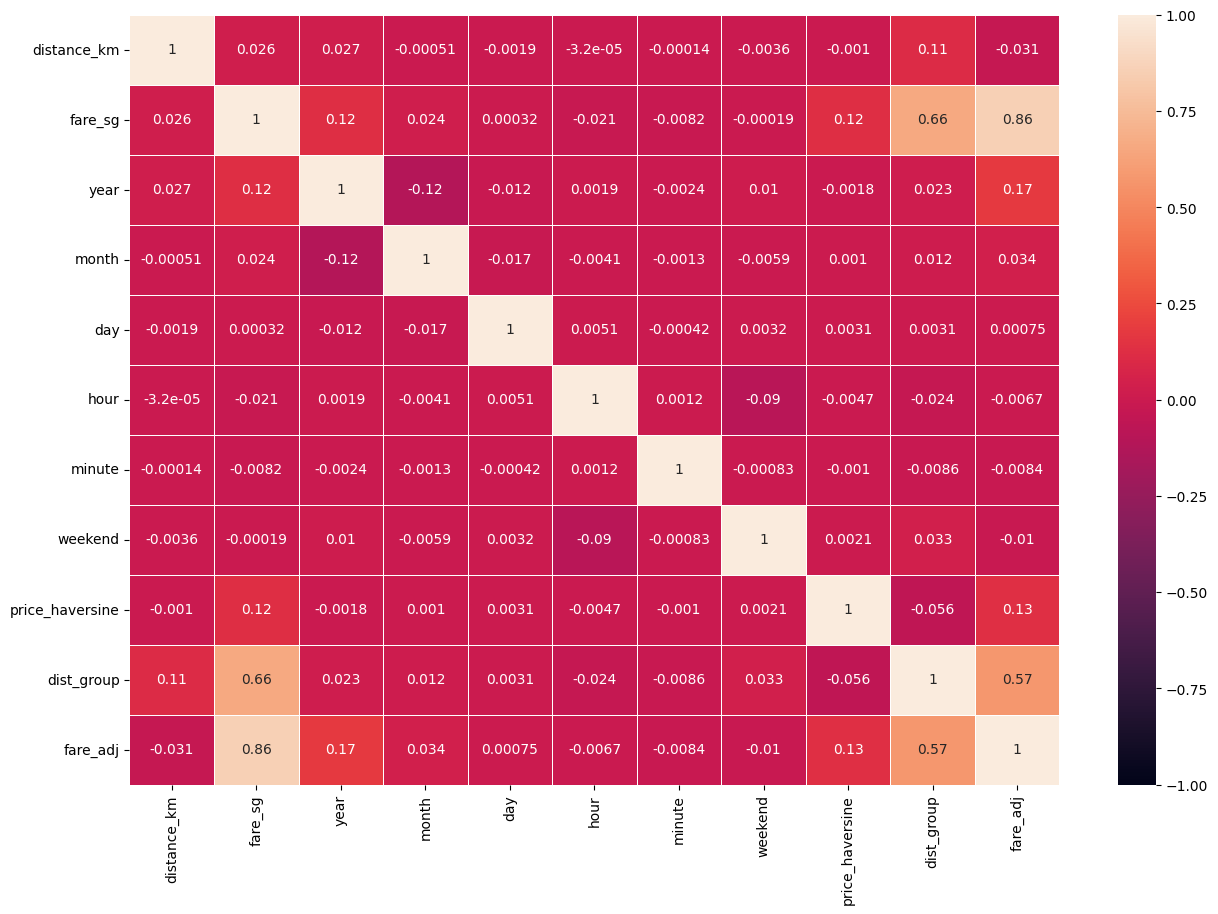

In [456]:
plt.figure(figsize=(15,10))
sns.heatmap(df_fare.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')

## Baseline linear model

In [457]:
#drop unscaled price
df_fare = df_fare.drop(['fare_sg'],axis=1)

In [458]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [459]:
X = df_fare.drop(['fare_adj'], axis = 1)
y = df_fare['fare_adj'].values.reshape(-1,1)

In [460]:
#std = StandardScaler()
onehot = OneHotEncoder(drop = 'first', # Drops the first category, so if there are m categories, we end up with m-1 new columns 
                       sparse = False  # Return a dense array (i.e. an ordinary array) instead of a sparse one
                      )

In [461]:
#X_num = std.fit_transform(X_train[['distance_km','year','month','day','hour','minute']])
#apply onehot encoder to cat columns
X_num = X[['distance_km','year','month','day','hour','minute']]
X_num = X_num.reset_index()
X_num = X_num.drop(['index'],axis=1)
X_cat = onehot.fit_transform(X[['day_of_week','weekend']])
#y_std = std.fit_transform(y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [462]:
#X_num = pd.DataFrame(X_num, columns = ['distance_km','year','month','day','hour','minute'])
X_cat = pd.DataFrame(X_cat, columns = onehot.get_feature_names_out())

In [463]:
#combine cat and num columns after encoder
X_std = pd.concat([X_num, X_cat], axis = 1)
#y_std = pd.DataFrame(y_std, columns = ['fare_sg'])

In [464]:
X_std

,distance_km,year,month,day,hour,minute,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,weekend_1
0,1.683325,2015,5,7,19,52,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.457593,2009,7,17,20,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.036384,2009,8,24,21,45,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.661686,2009,6,26,8,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.475456,2014,8,28,17,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194330,0.112210,2012,10,28,10,49,0.0,0.0,1.0,0.0,0.0,0.0,1.0
194331,1.875053,2014,3,14,1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194332,12.850337,2009,6,29,0,42,1.0,0.0,0.0,0.0,0.0,0.0,0.0
194333,3.539720,2015,5,20,14,56,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [465]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=2023)

In [466]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [467]:
y_pred = reg.predict(X_test)

In [468]:
y_pred

array([[ 9.96629733],
       [12.03043894],
       [12.99156822],
       ...,
       [11.45706427],
       [ 9.98990239],
       [10.13528535]])

In [469]:
#R^2
print(f'validation R^2: {r2_score(y_test, y_pred)}')
print(f'train R^2: {r2_score(y_train,reg.predict(X_train))}')
#MSE
print(f'validation MSE: {mean_squared_error(y_test, y_pred)}')
print(f'train MSE: {mean_squared_error(y_train, reg.predict(X_train))}')

validation R^2: 0.04092219668004704
train R^2: 0.03331275941890288
validation MSE: 27.879421362375314
train MSE: 32.602123963440576


In [470]:
print(f'test MAE:{metrics.mean_absolute_error(y_test, y_pred)}')

test MAE:3.7711852485524338


## Decision tree & Random forest regressor

In [471]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [472]:
y_pred_dt = dt.predict(X_test)

In [473]:
y_pred_dt

array([ 9.75,  5.03,  8.63, ..., 13.84,  7.03,  5.16])

In [474]:
#R^2
print(f'validation R^2: {r2_score(y_test, y_pred_dt)}')
print(f'train R^2: {r2_score(y_train,dt.predict(X_train))}')
#MSE
print(f'validation MSE: {mean_squared_error(y_test, y_pred_dt)}')
print(f'train MSE: {mean_squared_error(y_train, dt.predict(X_train))}')

validation R^2: -0.15787415244524516
train R^2: 1.0
validation MSE: 33.658230092366274
train MSE: 3.7805885388475143e-32


In [475]:
print(f'test MAE:{metrics.mean_absolute_error(y_test, y_pred_dt)}')

test MAE:3.0255126456891452


In [476]:
#Random forest regressor
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

/var/folders/gq/27tc954x38q2y4b000rzczsr0000gq/T/ipykernel_25641/518351464.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


RandomForestRegressor()

In [477]:
y_pred_rf = RF.predict(X_test)

In [478]:
#R^2
print(f'test R^2: {r2_score(y_test, y_pred_rf)}')
print(f'train R^2: {r2_score(y_train,RF.predict(X_train))}')
#MSE
print(f'validation MSE: {mean_squared_error(y_test, y_pred_rf)}')
print(f'train MSE: {mean_squared_error(y_train, RF.predict(X_train))}')
#MAE
print(f'test MAE:{metrics.mean_absolute_error(y_test, y_pred_rf)}')

test R^2: 0.48928816865348035
train R^2: 0.9240722653883586
validation MSE: 14.84587620688579
train MSE: 2.5607097230164406
test MAE:2.163500602053156


In [479]:
#table of actual VS predicted
pd.concat([pd.DataFrame(y_test, columns = ['actual']), pd.DataFrame(y_pred_rf, columns=['predicted'])], axis = 1)

,actual,predicted
0,7.35,11.3008
1,5.66,6.9951
2,6.78,8.3934
3,8.51,8.1134
4,31.54,23.2215
...,...,...
38862,6.04,7.3616
38863,10.86,13.3403
38864,10.24,12.6108
38865,5.55,7.8874


# Mimic actual data input in the form of address & current time

In [40]:
#address to long and lat converter
#query current time
#process data to fit into current format
#predict
import requests

access_key = 'd2bd91704c97c44710daab267b9fdcce'
function_name = '1600 Pennsylvania Ave NW, Washington DC'
url="http://api.positionstack.com/v1/forward?access_key={}&query={}".format(access_key,function_name)
print(url)
# url='http://api.positionstack.com/v1/reverse?access_key={}&query=40.7638435,-73.9729691'.format(access_key)
res = requests.get(url)
data = res.json()
print(data)

http://api.positionstack.com/v1/forward?access_key=d2bd91704c97c44710daab267b9fdcce&query=1600 Pennsylvania Ave NW, Washington DC
{'data': [{'latitude': 38.897675, 'longitude': -77.036547, 'type': 'address', 'name': '1600 Pennsylvania Avenue NW', 'number': '1600', 'postal_code': '20500', 'street': 'Pennsylvania Avenue NW', 'confidence': 1, 'region': 'District of Columbia', 'region_code': 'DC', 'county': 'District of Columbia', 'locality': 'Washington', 'administrative_area': None, 'neighbourhood': 'White House Grounds', 'country': 'United States', 'country_code': 'USA', 'continent': 'North America', 'label': '1600 Pennsylvania Avenue NW, Washington, DC, USA', 'map_url': 'https://map.positionstack.com/export/embed.html?bbox=-77.036047,38.898175,-77.037047,38.897175&layer=mapnik&marker=38.897675,-77.036547'}, {'latitude': 38.897473, 'longitude': -77.036548, 'type': 'address', 'name': '1600 Pennsylvania Avenue Northwest', 'number': '1600', 'postal_code': '20500', 'street': 'Pennsylvania A

In [480]:
import requests
from datetime import datetime
from datetime import timedelta

In [501]:
#Pick up address
access_key = "d2bd91704c97c44710daab267b9fdcce"
pickup = "501 Jln. Ahmad Ibrahim, Singapore 639937"
url = f"http://api.positionstack.com/v1/forward?access_key={access_key}&query={pickup}"

response = requests.get(url)
pickup = response.json()

#Drop off address
access_key = "d2bd91704c97c44710daab267b9fdcce"
dropoff = "65 Airport Blvd., Level 2 Terminal 3, Singapore 819663"
url = f"http://api.positionstack.com/v1/forward?access_key={access_key}&query={dropoff}"

response = requests.get(url)
dropoff = response.json()

#Record current time
currentTime = datetime.now()

In [502]:
#Add n minutes to current datetime
n = 10
futureTime = currentTime + timedelta(minutes=n)
print(futureTime)
print(currentTime)
# Convert datetime object to string in specific format 
#final_time_str = final_time.strftime('%d/%m/%Y %H:%M:%S.%f')
#print('Final Time as string object: ', final_time_str)

2023-03-04 19:05:39.058063
2023-03-04 18:55:39.058063


In [503]:
#convert returned long and lat to haversine distance
def AddtoDis(pickup, dropoff):
    PickupLat = pickup['data'][0]['latitude']
    PickupLong = pickup['data'][0]['longitude']
    DropoffLat = dropoff['data'][0]['latitude']
    DropoffLong = dropoff['data'][0]['longitude']
    haversineDis = haversineDist(PickupLong,DropoffLong,PickupLat,DropoffLat)
    return [haversineDis]

In [484]:
AddtoDis(pickup, dropoff)

[15.19416135885029]

In [348]:
pickup

{'data': [{'latitude': 1.296332,
   'longitude': 103.850055,
   'type': 'venue',
   'name': 'Li Ka Shing Library',
   'number': '70',
   'postal_code': '178901',
   'street': 'Stamford Road',
   'confidence': 1,
   'region': 'Central Singapore',
   'region_code': 'CS',
   'county': None,
   'locality': 'Singapore',
   'administrative_area': None,
   'neighbourhood': None,
   'country': 'Singapore',
   'country_code': 'SGP',
   'continent': 'Asia',
   'label': 'Li Ka Shing Library, Singapore'}]}

In [349]:
dropoff

{'data': [{'latitude': 1.432733,
   'longitude': 103.841904,
   'type': 'address',
   'name': '315 Yishun Avenue 6',
   'number': '315',
   'postal_code': '760315',
   'street': 'Yishun Avenue 6',
   'confidence': 1,
   'region': 'Central Singapore',
   'region_code': 'CS',
   'county': None,
   'locality': 'Singapore',
   'administrative_area': None,
   'neighbourhood': None,
   'country': 'Singapore',
   'country_code': 'SGP',
   'continent': 'Asia',
   'label': '315 Yishun Avenue 6, Singapore'},
  {'latitude': 1.433332,
   'longitude': 103.843136,
   'type': 'venue',
   'name': 'Yishun Greenwalk',
   'number': None,
   'postal_code': None,
   'street': None,
   'confidence': 1,
   'region': 'Central Singapore',
   'region_code': 'CS',
   'county': None,
   'locality': 'Singapore',
   'administrative_area': None,
   'neighbourhood': None,
   'country': 'Singapore',
   'country_code': 'SGP',
   'continent': 'Asia',
   'label': 'Yishun Greenwalk, Singapore'},
  {'latitude': 1.431606,
 

In [485]:
#convert current time to training data format
def ConvertTime(currentTime):
    Time = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    year = currentTime.strftime("%Y")
    month = currentTime.strftime("%m")
    day = currentTime.strftime("%d")
    hour = currentTime.strftime("%H")
    minute = currentTime.strftime("%M")
    day_of_week = currentTime.strftime("%A")
    
    if day_of_week == "Saturday" or day_of_week == "Sunday":
        weekend = 1
    else: 
        weekend = 0
    return [year,month,day,day_of_week,hour,minute,weekend]

In [486]:
ConvertTime(currentTime)

['2023', '03', '04', 'Saturday', '18', '44', 1]

In [495]:
#convert list of time and distance to dataframe
def ConvertDataframe(time, dist):
    ColName = ['year','month','day','day_of_week','hour','minute','weekend','distance_km']
    df_newreq = pd.DataFrame(time + dist).T
    df_newreq.columns = ColName
    df_newreq = df_newreq.astype({"distance_km": float, "year": int,"month": int, "day": int,"day_of_week": str,"hour": int, "minute": int})
    return df_newreq

In [504]:
df_newreg = ConvertDataframe(ConvertTime(futureTime),AddtoDis(pickup, dropoff))

In [505]:
df_newreg

,year,month,day,day_of_week,hour,minute,weekend,distance_km
0,2023,3,4,Saturday,19,5,1,17.525479


In [506]:
df_num = df_newreg[['distance_km','year','month','day','hour','minute']]
cat = onehot.transform(df_newreg[['day_of_week','weekend']])

In [507]:
df_cat = pd.DataFrame(cat, columns = onehot.get_feature_names_out())
df_std_new = pd.concat([df_num, df_cat], axis = 1)
df_std_new

,distance_km,year,month,day,hour,minute,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,weekend_1
0,17.525479,2023,3,4,19,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [492]:
#Predicted fare in SGD at Pickup&dropoff location at 10 minutes after current time
RF.predict(df_std_new)

#actual JustGrab price from SMU Lib to Yishun: 20.64~28.38 at 6.45pm on 4th March (dis: 10+km)

array([19.5712])

In [500]:
RF.predict(df_std_new)

#actual JustGrab price from SMU Lib to Chinatownpoint: 9.44~12.98 at 6.48pm on 4th March (dis: 1.37km)

array([8.4205])